# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

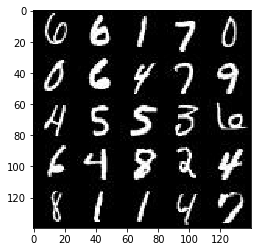

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

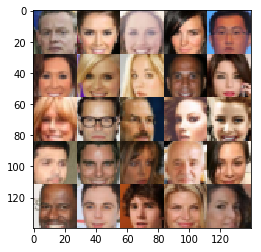

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [25]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(),name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: min threshold multiplier for leaky relu
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 28x28x3 Input layer goes through a conv layer with leaky RELU without batch norm
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same' )
        relu1 = tf.maximum(layer1 * alpha, layer1)
        # 14x14x64 now
        
        # Two convolutional layers with batch norm and leaky RELU
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same' )
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        # 7x7x128 now

        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same' )
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)
        # 4x4x256 now
        
        # Pass the flattened output of the convolutional layers into an FC layer
        flat = tf.reshape(relu3 , (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: min threshold multiplier for leaky relu
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        
        # Pass the input through an FC layer and reshape it
        fc1 = tf.layers.dense(z, 7*7*512)
        layer1 = tf.reshape(fc1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(bn1*alpha, bn1)
        # 7x7x512 now
        
        layer2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(bn2*alpha, bn2)
        # 7x7x256 now
        
        layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(bn3*alpha, bn3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xchannel_dim now
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :param alpha: min threshold multiplier for leaky relu
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    # TODO: Implement Function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get trainable variables for each scope
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize while ensuring population statistics are updated
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    if(data_image_mode=='RGB'):
        image_channels = 3
    else:
        image_channels = 1
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_count = 0
    print_every = 50 # frequency at which to display losses
    show_every = 100 # frequency at which to display image outputs
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_count += 1
                # Random noise for the generator input
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers and double batch_image range to get it to (-1, 1) range 
                _ = sess.run(d_train_opt, feed_dict = {input_real : batch_images * 2, input_z : batch_z,
                                                       l_rate : learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_real : batch_images * 2, input_z : batch_z,
                                                       l_rate : learning_rate})
                
                if batch_count % print_every == 0:
                    # get losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images * 2})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if batch_count % show_every == 0:
                    show_generator_output(sess, 32, input_z, image_channels, data_image_mode)
                                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 1.0434
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 0.9542


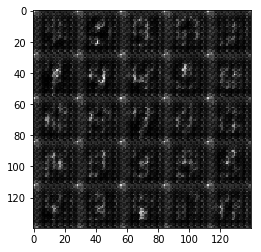

Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 1.0497


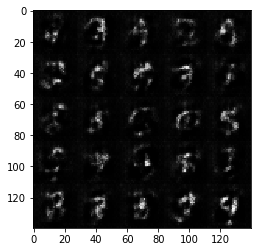

Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.1723
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.6064


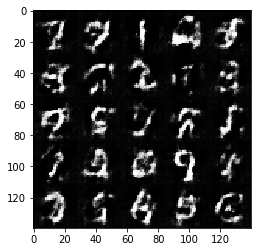

Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.2580
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.8716


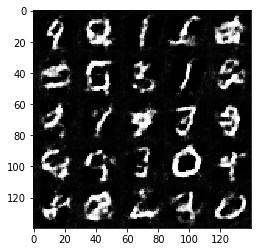

Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.1960


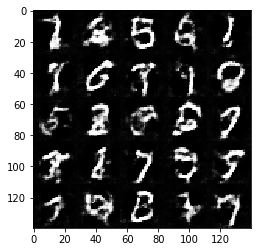

Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 1.5107


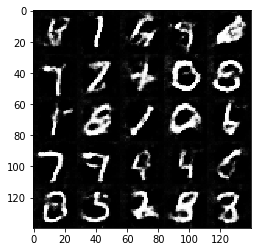

Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.6390
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.7964


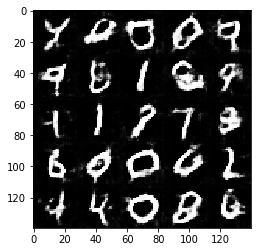

Epoch 2/2... Discriminator Loss: 1.0626... Generator Loss: 1.4821
Epoch 2/2... Discriminator Loss: 2.0535... Generator Loss: 3.0938


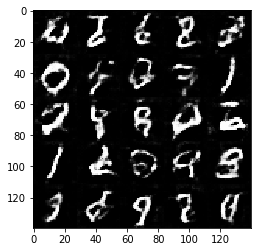

Epoch 2/2... Discriminator Loss: 1.3425... Generator Loss: 0.5436
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 0.7097


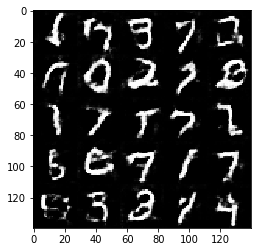

In [31]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.7711
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 1.5084


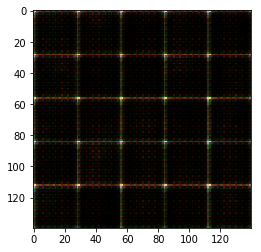

Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 1.5626


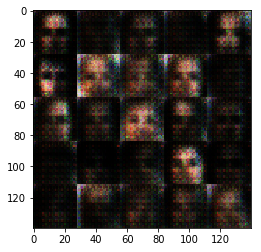

Epoch 1/1... Discriminator Loss: 1.9205... Generator Loss: 0.3660
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.1285


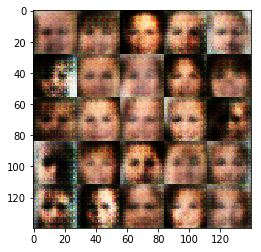

Epoch 1/1... Discriminator Loss: 1.9920... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7825


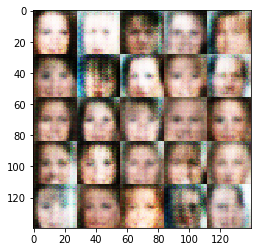

Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.8732


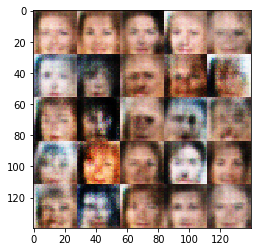

Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8565


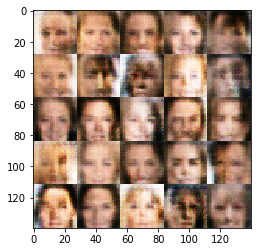

Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8750


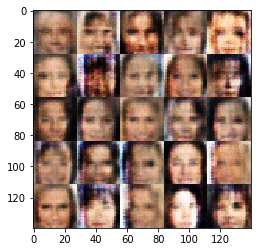

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6820


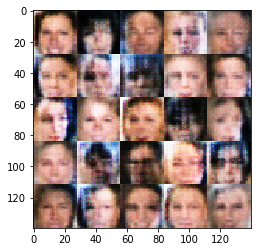

Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.8017


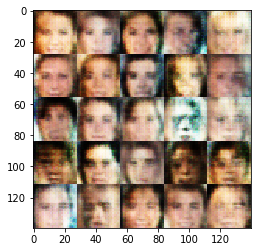

Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8907


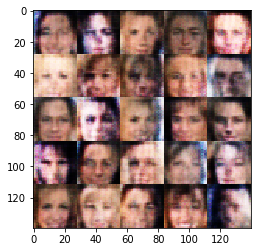

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7792


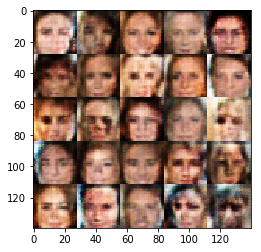

Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7866


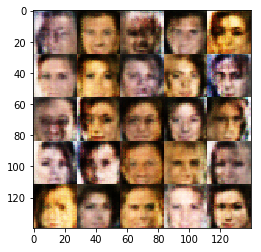

Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7509


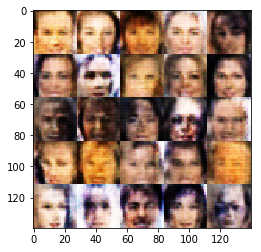

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9562


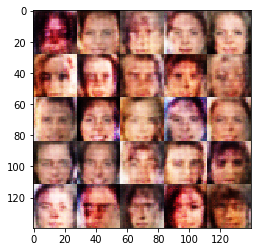

Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7911


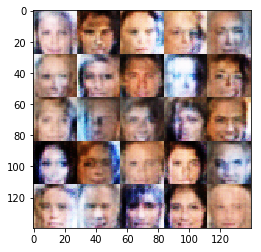

Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.5756


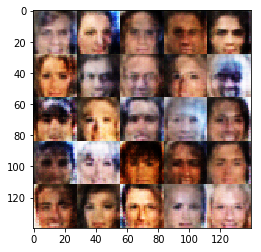

Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6358


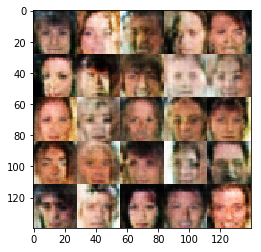

Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.9428


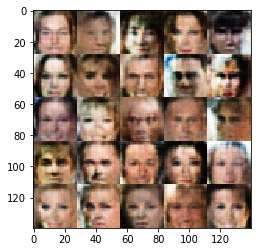

Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5097


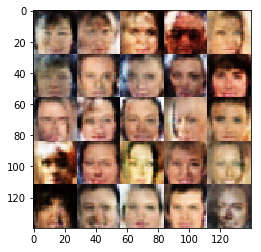

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8633


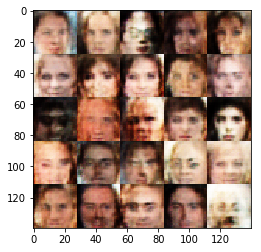

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6593


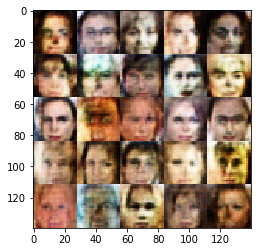

Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.6102


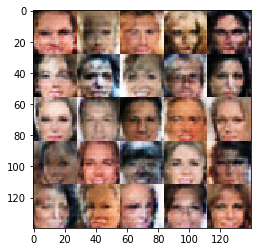

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7734


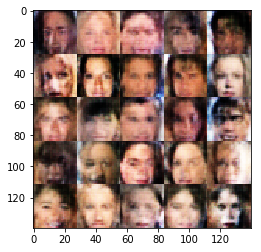

Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8817


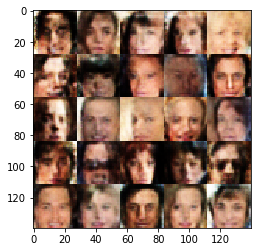

Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.9170


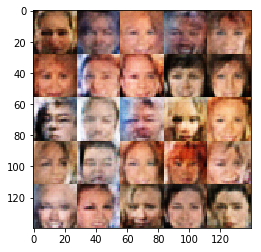

Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.2204


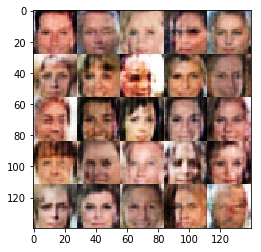

Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5664


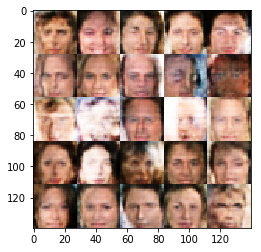

Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7147


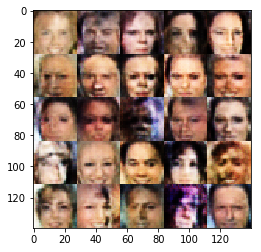

Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8952


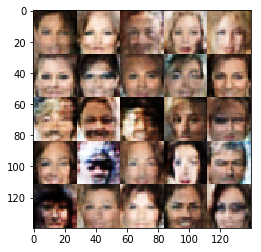

Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.8424


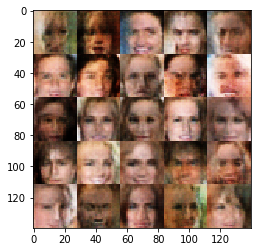

Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.0350


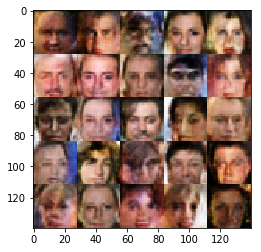

Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.8895


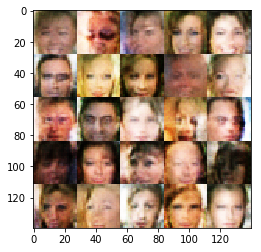

Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.0030


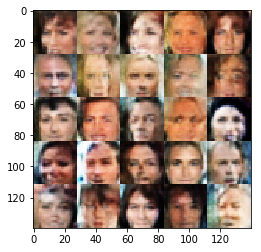

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.8894


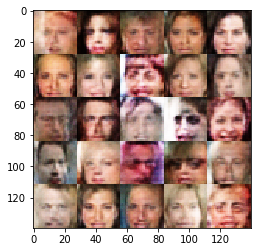

Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6770


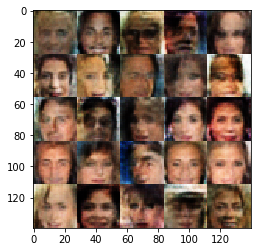

Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6243


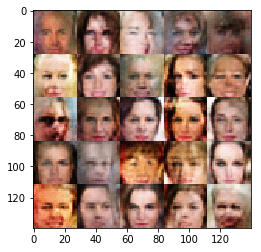

Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.5833


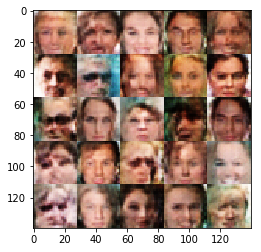

Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7693


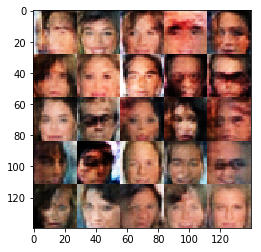

Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.7830


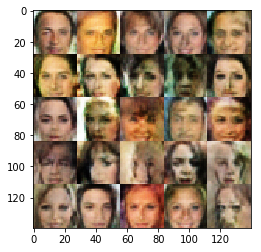

Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5942


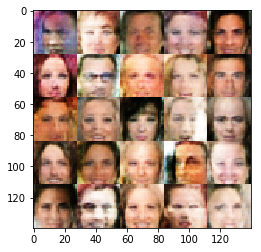

Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.9526


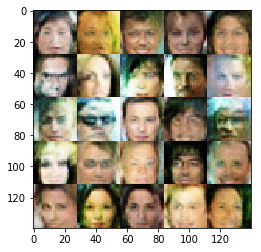

Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6481


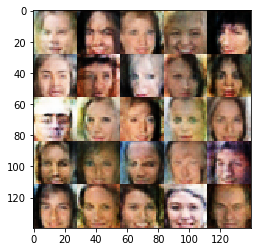

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.0021


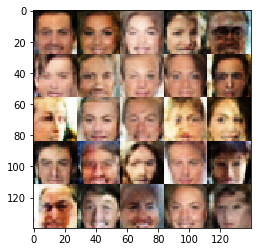

Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.1640


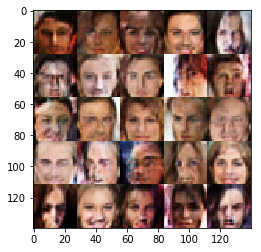

Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.5467


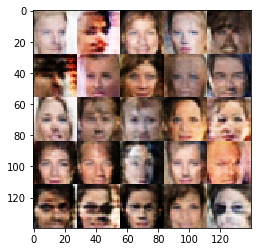

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.9563


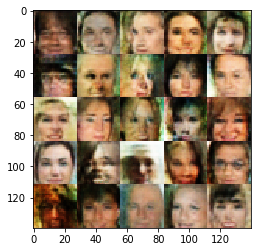

Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6422


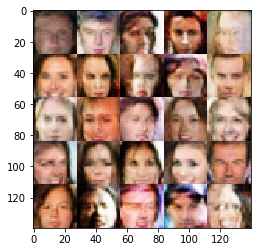

Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.6264


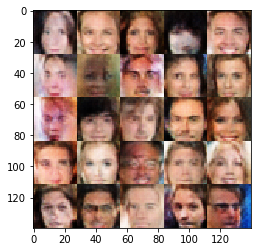

Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7366


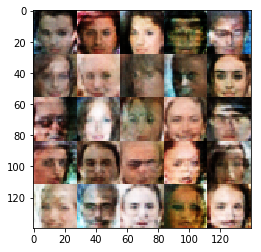

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6871


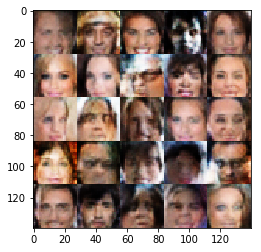

Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5048


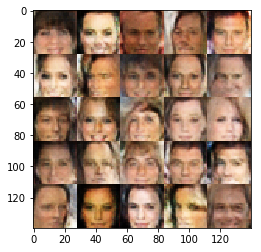

Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.4362


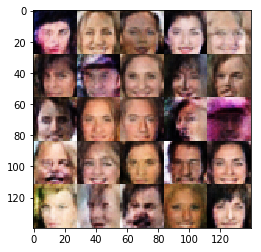

Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.0397


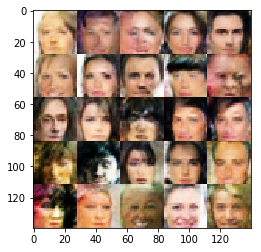

Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.6422


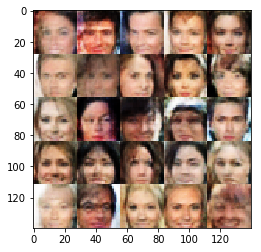

Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.6397


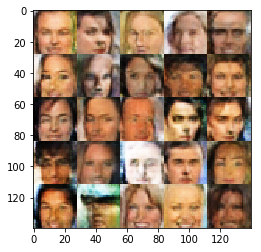

Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.9510


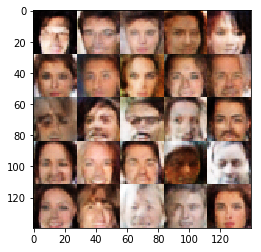

Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6600


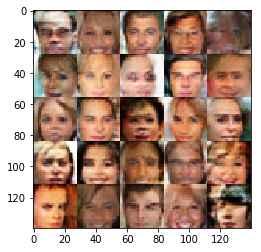

Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.4127


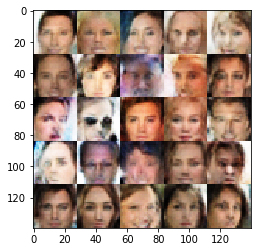

Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8484


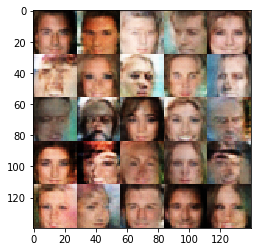

Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.7701


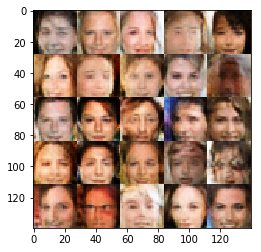

Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6005


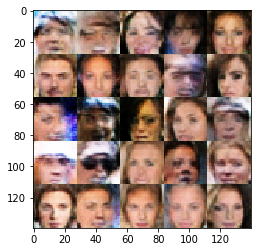

Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6765


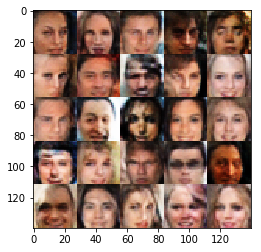

Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7749


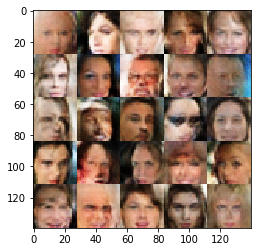

In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.